In [1]:
import os

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf

# Disable GPU
tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices([], 'GPU')

# Disable GPU
tf.config.set_visible_devices([], 'GPU')

## Import Relevant Libraries for Training

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Concatenate, Reshape, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Nadam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import cv2
import mplcursors
from tqdm import tqdm

### Load Dataset

In [2]:
# Load CSV data
csv_path = r'Dimentia Dataset\dementia_dataset.csv'
data = pd.read_csv(csv_path)
data = data.fillna(0)

print(data.columns)
for column in data.drop(columns=['Group', 'Subject ID', 'MRI ID']).columns:
        data[column] = data[column].astype('category').cat.codes

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')


In [3]:
def generate_data(df, extra_trees_classifier):
    X = df[['Age', 'EDUC', 'Visit', 'MR Delay', 'Hand', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]
    print(f'Number of Features before feature selection {X.shape}')
    y = df['Group'] # set the y to the dependent output variable
    model = extra_trees_classifier()
    model.fit(X,y)
    print(model)
    return X, y, model
    
X, y, model = generate_data(data, ExtraTreesClassifier)

Number of Features before feature selection (372, 11)
ExtraTreesClassifier()


In [4]:
def encode_output(y):
    onehot = pd.get_dummies(y)
    output = onehot.to_numpy()
    
    return output

In [5]:
print(X.shape)
print(X[:5])

(372, 11)
   Age  EDUC  Visit  MR Delay  Hand  SES  MMSE  CDR  eTIV  nWBV  ASF
0   28     5      1        15     0    2    18    0   284    20    0
1   15     3      0         0     0    0    11    1   231    73   51
2   16     3      1        32     0    0    16    1   254    51   31
3   20     3      2       185     0    0    10    1   238    40   45
4   28     9      0         0     0    3    16    0    16    48  247


In [6]:
print(y.shape)
print(y[:5])

(372,)
0    Nondemented
1       Demented
2       Demented
3       Demented
4    Nondemented
Name: Group, dtype: object


In [7]:
def output_stats(y):
    y = pd.DataFrame(y)
    print (y.shape)
    
    y.columns = y.columns.str.strip() #to remove white spaces from column headers

    imbalance = y.Group.value_counts() #check dataset for imbalances
    
    #imbalanace is the distribution of the training outcome. If the dataset is bias with more outcomes, the model will be better at predicting that outcome
    if(imbalance.shape[0] > 1): # condition prevents code from throwing error if the dataset has only on type of output (e.g., 0 for days without intrusion)
        print(f'imbalance of this predicted variable is: {round(imbalance[0]/imbalance[1], 2) * 100}% \n\nImbalance Variables\n{imbalance}')
    return y

y_stats = output_stats(y)

(372, 1)
imbalance of this predicted variable is: 129.0% 

Imbalance Variables
Nondemented    189
Demented       146
Converted       37
Name: Group, dtype: int64


In [8]:
y_encoded = encode_output(y)
print(y_encoded.shape)
print(y_encoded[:5])

(372, 3)
[[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


### Preprocess Data

In [9]:
def extra_tree_classifier(threshold, model, X, df):

    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    print(feat_importances)
    correlations = feat_importances.nlargest(df.shape[1])

    df = pd.DataFrame(correlations).reset_index()
    df.columns = ['features', 'data']
    
    df_output = df[df['data'] >= threshold]
    
    #This is to ensure the feature selector returns features when feature correlation between X and y is 0 
    while df_output.shape[0] < 3: # features must be a minimum of 3
        
        print(f'Current Feature size before adjustment: {df_output.shape[0]}')
        threshold = round(threshold - 0.01, 2) # reduced threshold by 1% to increase number of threshold
        print(f'New Threshold: {threshold}')
        df_output = df[df['data'] >= threshold]
        print(f'Current Feature size after adjustment: {df_output.shape[0]}')
        if(threshold == 0):
            print(f'Final Correlation: {threshold * 100}%')
            break
                
    tooltip = df.data
    tt = [str(round((ttip * 100), 2)) + '% correlation' for ttip in tooltip.values]
    
    fig, ax = plt.subplots(1, figsize=(9.5,5.5))
    
    ax.bar(df['features'], df['data'], align="center")
    cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set(text=tt[sel.target.index])
        
    plt.title('Feature Correlation with Output - Label\n', loc='left', fontsize=22)
    plt.xlabel('Features')
    plt.yticks(fontsize=8)
    plt.xticks(rotation = 90, fontsize=8)
    plt.ylabel('Correlations')
    plt.tight_layout()
    plt.margins(x=0)
    plt.show()
       
    
    return df_output

Age         0.044942
EDUC        0.048816
Visit       0.021405
MR Delay    0.043721
Hand        0.000000
SES         0.054742
MMSE        0.150439
CDR         0.484300
eTIV        0.046376
nWBV        0.061092
ASF         0.044167
dtype: float64


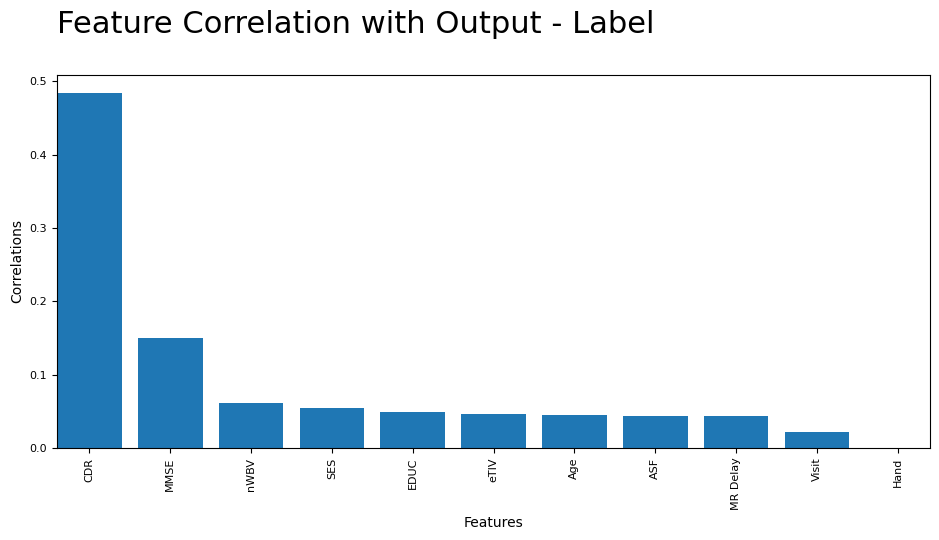

In [10]:
selected_features = extra_tree_classifier(0.04, model, X, data)

In [11]:
def reshape_input(data, alt_time_steps):
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    # Reshape the data into a 3D array
    num_samples = data.shape[0] 
    num_features = data.shape[1]
    input = np.zeros((num_samples, alt_time_steps, num_features))
    for i in range(num_samples):
        if i+alt_time_steps < num_samples:
            input[i, :, :] = data[i:i+alt_time_steps, :]
            
    return input

In [12]:
def load_images(folder_path):
    images_dict = {}
    desired_size = (200, 200, 3)

    for root, dirs, files in tqdm(os.walk(folder_path), desc="Processing"):
#         print(root)
        # Skip the first entry (root is empty)
        if not files:
            continue
        
        # Sort the directories alphabetically
        dirs.sort()

        patient_images = []
        for file in sorted(files):  # Sort files alphabetically
            if file.endswith('.png') and "nifti" in file:
                # get image path
                image_path = os.path.join(root, file)

                # Load the header and image data
                image = keras.preprocessing.image.load_img(image_path, target_size=desired_size[:-1])
                image = keras.preprocessing.image.img_to_array(image)

                # Convert the image to RGB format
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Normalize the image to the range [0, 1]
                image = image.astype('float32') / 255.0

                # Append the preprocessed image to the list
                patient_images.append(image)

        # Store images in a dictionary with the folder as the key
        images_dict[root] = np.array(patient_images)

    # Convert the dictionary values to a NumPy array
    images_list = list(images_dict.values())
    images = np.array(images_list, dtype=object)

    return images

In [13]:
image_path = r'Dimentia Dataset/Output'
images = load_images(image_path)
images_sequences = np.array(images)
print(images_sequences.shape)

Processing: 373it [00:03, 111.12it/s]

(372,)


In [14]:
max_num_images = 4
image_shape = (200, 200, 3)
padded_images_sequence = [np.pad(sequence, ((0, max_num_images - sequence.shape[0]), (0, 0), (0, 0), (0, 0)), mode='constant') for sequence in images_sequences]
image_data = np.stack(padded_images_sequence)
desired_shape = (image_data[0].shape)
print(desired_shape)

(4, 200, 200, 3)


In [15]:
time_step = 4
X = X[selected_features['features']]
X_reshaped = reshape_input(X, time_step)
print(X_reshaped.shape)
print(y_encoded.shape)

(372, 4, 9)
(372, 3)


In [16]:
# Define the MLP network for tabular data
class classifier():
    def __init__(self, num_tabular_features, desired_image_shape, time_step):
        self.num_tabular_features = num_tabular_features
        self.desired_image_shape = desired_image_shape
        self.num_features = num_tabular_features
        self.time_step = time_step
        self.tabular_model = None
        self.image_model = None
        self.multi_modal_model = None
    
    def tabular_classifier(self):
        tabular_model = Sequential(name="tabular_classifier")
        tabular_model.add(LSTM(256, input_shape=(self.time_step, self.num_features), activation='relu', dropout=0.2))
        tabular_model.add(Dense(3, activation='relu'))
        tabular_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
        
        return tabular_model

    # Define the CNN network for image data
    def image_classifier(self):
#         image_model = Sequential(name="image_classifier")
        image_input = Input(shape=self.desired_image_shape)
        image_conv1 = TimeDistributed(Conv2D(128, 1, activation='tanh', padding='valid'))(image_input)
        image_maxpool1 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(image_conv1)
        image_conv2 = TimeDistributed(Conv2D(256, 1, activation='tanh', padding='valid'))(image_maxpool1)
        image_maxpool2 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(image_conv2)
        image_flat = TimeDistributed(Flatten())(image_maxpool2)
        
        # Combine the sequence of flattened images along the time axis
        combined_image_features = Concatenate(axis=-1)([image_flat])
        # Flatten the time-distributed sequence
        flattened_features = Flatten()(combined_image_features)
        image_output = Dense(3, activation='softmax')(flattened_features)
        image_model = Model(inputs=image_input, outputs=image_output, name="image_classifier")
        image_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        return image_model
      
    def build_classifier(self):
        self.tabular_model = self.tabular_classifier()
        self.image_model = self.image_classifier()

        # Combine the feature vectors using concatenation
        combined_features = Concatenate()([self.tabular_model.output, self.image_model.output])

        # Fusion Layer: You can add additional layers here if needed
        fusion_layer = Dense(128, activation='sigmoid')(combined_features)

        # Output Layer for binary classification
        output_layer = Dense(3, activation='softmax')(fusion_layer)

        # Create the siamese network
        self.multi_modal_model = Model(inputs=[self.tabular_model.input, self.image_model.input], outputs=output_layer, name="dimentia_classifier")

        # Compile the model
        self.multi_modal_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
al_classifier = classifier(len(selected_features), desired_shape, time_step)
al_classifier.build_classifier()
al_classifier.tabular_model.summary()
al_classifier.image_model.summary()

Model: "tabular_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               272384    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 273,155
Trainable params: 273,155
Non-trainable params: 0
_________________________________________________________________
Model: "image_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 200, 200, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 200, 200, 128)  512      
 ibuted)                                                         
                

In [18]:
al_classifier.multi_modal_model.summary()

Model: "dimentia_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 200, 200  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 4, 200, 200,  512        ['input_1[0][0]']                
 ted)                            128)                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 4, 100, 100,  0          ['time_distributed[0][0]']       
 buted)                          128)                                           

In [19]:
from sklearn.model_selection import train_test_split

# Assuming X_tabular, X_images, and y_reshaped are NumPy arrays

# Split the data into training and testing sets while maintaining the correspondence
X_tabular_train, X_tabular_test, X_images_train, X_images_test, y_train, y_test = train_test_split(
    X_reshaped, image_data, y_encoded, test_size=0.2, random_state=42
)

# Print the shapes of the resulting arrays
print("X_tabular_train shape:", X_tabular_train.shape)
print("X_tabular_test shape:", X_tabular_test.shape)
print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_tabular_train shape: (297, 4, 9)
X_tabular_test shape: (75, 4, 9)
X_images_train shape: (297, 4, 200, 200, 3)
X_images_test shape: (75, 4, 200, 200, 3)
y_train shape: (297, 3)
y_test shape: (75, 3)


In [20]:
# # Enable eager execution
# tf.config.run_functions_eagerly(True)

In [21]:
# Train the model
history = al_classifier.multi_modal_model.fit([X_tabular_train, X_images_train], 
              y_train,
              verbose=1,
              use_multiprocessing=True,
              workers=32,
              validation_data=([X_tabular_test, X_images_test], y_test), 
              epochs=200)

Epoch 1/200
10/10 [==============================] - 102s 10s/step - loss: 1.4007 - accuracy: 0.1347 - val_loss: 1.0707 - val_accuracy: 0.3867
Epoch 2/200
10/10 [==============================] - 109s 11s/step - loss: 0.9718 - accuracy: 0.5017 - val_loss: 1.0507 - val_accuracy: 0.4000
Epoch 3/200
10/10 [==============================] - 120s 12s/step - loss: 0.9138 - accuracy: 0.5253 - val_loss: 1.0756 - val_accuracy: 0.3867
Epoch 4/200
10/10 [==============================] - 121s 12s/step - loss: 0.9009 - accuracy: 0.5387 - val_loss: 1.0652 - val_accuracy: 0.4267
Epoch 5/200
10/10 [==============================] - 147s 15s/step - loss: 0.8863 - accuracy: 0.5589 - val_loss: 1.0540 - val_accuracy: 0.4800
Epoch 6/200
10/10 [==============================] - 135s 13s/step - loss: 0.8497 - accuracy: 0.6263 - val_loss: 1.0718 - val_accuracy: 0.4933
Epoch 7/200
10/10 [==============================] - 159s 16s/step - loss: 0.8651 - accuracy: 0.5993 - val_loss: 1.0854 - val_accuracy: 0.5200

10/10 [==============================] - 96s 10s/step - loss: 0.5816 - accuracy: 0.7980 - val_loss: 1.1718 - val_accuracy: 0.4933
Epoch 59/200
10/10 [==============================] - 98s 10s/step - loss: 0.5902 - accuracy: 0.7710 - val_loss: 0.7670 - val_accuracy: 0.6800
Epoch 60/200
10/10 [==============================] - 103s 10s/step - loss: 0.5955 - accuracy: 0.7912 - val_loss: 0.6870 - val_accuracy: 0.7467
Epoch 61/200
10/10 [==============================] - 102s 10s/step - loss: 0.5857 - accuracy: 0.7980 - val_loss: 0.9830 - val_accuracy: 0.6133
Epoch 62/200
10/10 [==============================] - 93s 9s/step - loss: 0.6437 - accuracy: 0.7441 - val_loss: 0.7382 - val_accuracy: 0.7200
Epoch 63/200
10/10 [==============================] - 98s 10s/step - loss: 0.5145 - accuracy: 0.8047 - val_loss: 0.9429 - val_accuracy: 0.6400
Epoch 64/200
10/10 [==============================] - 101s 10s/step - loss: 0.5646 - accuracy: 0.7710 - val_loss: 1.0922 - val_accuracy: 0.5467
Epoch 65/2

10/10 [==============================] - 108s 11s/step - loss: 0.4261 - accuracy: 0.8721 - val_loss: 0.5738 - val_accuracy: 0.7867
Epoch 116/200
10/10 [==============================] - 98s 10s/step - loss: 0.3278 - accuracy: 0.8923 - val_loss: 0.5110 - val_accuracy: 0.7867
Epoch 117/200
10/10 [==============================] - 93s 9s/step - loss: 0.3711 - accuracy: 0.8721 - val_loss: 0.5156 - val_accuracy: 0.8267
Epoch 118/200
10/10 [==============================] - 103s 10s/step - loss: 0.3478 - accuracy: 0.8687 - val_loss: 0.8904 - val_accuracy: 0.7067
Epoch 119/200
10/10 [==============================] - 105s 10s/step - loss: 0.5200 - accuracy: 0.8081 - val_loss: 0.6073 - val_accuracy: 0.7733
Epoch 120/200
10/10 [==============================] - 106s 11s/step - loss: 0.4071 - accuracy: 0.8721 - val_loss: 0.8936 - val_accuracy: 0.6800
Epoch 121/200
10/10 [==============================] - 111s 11s/step - loss: 0.4422 - accuracy: 0.8485 - val_loss: 0.8851 - val_accuracy: 0.6533
Ep

Epoch 172/200
10/10 [==============================] - 112s 11s/step - loss: 0.2936 - accuracy: 0.9158 - val_loss: 0.6612 - val_accuracy: 0.8133
Epoch 173/200
10/10 [==============================] - 120s 12s/step - loss: 0.2956 - accuracy: 0.9057 - val_loss: 0.5911 - val_accuracy: 0.8267
Epoch 174/200
10/10 [==============================] - 102s 10s/step - loss: 0.2803 - accuracy: 0.8889 - val_loss: 0.4851 - val_accuracy: 0.8267
Epoch 175/200
10/10 [==============================] - 93s 9s/step - loss: 0.2759 - accuracy: 0.9192 - val_loss: 0.8226 - val_accuracy: 0.6800
Epoch 176/200
10/10 [==============================] - 100s 10s/step - loss: 0.3015 - accuracy: 0.8923 - val_loss: 0.5439 - val_accuracy: 0.8267
Epoch 177/200
10/10 [==============================] - 107s 11s/step - loss: 0.2729 - accuracy: 0.9125 - val_loss: 0.4270 - val_accuracy: 0.8400
Epoch 178/200
10/10 [==============================] - 109s 11s/step - loss: 0.2439 - accuracy: 0.9327 - val_loss: 0.4868 - val_accu

### Save Dimentia Classifier Model

In [22]:
al_classifier.multi_modal_model.save('dimentia_detector_v1.h5')
al_classifier.image_model.save('image_detector_v1.h5')
al_classifier.tabular_model.save('tabular_detector_v1.h5')
al_classifier.multi_modal_model.save('dimentia_detector_v_1', save_format='tf')
al_classifier.image_model.save('image_detector_v_1', save_format='tf')
al_classifier.tabular_model.save('tabular_detector_v_1', save_format='tf')

INFO:tensorflow:Assets written to: dimentia_detector_v_1\assets


INFO:tensorflow:Assets written to: dimentia_detector_v_1\assets


INFO:tensorflow:Assets written to: image_detector_v_1\assets


INFO:tensorflow:Assets written to: image_detector_v_1\assets


INFO:tensorflow:Assets written to: tabular_detector_v_1\assets


INFO:tensorflow:Assets written to: tabular_detector_v_1\assets


### Evaluate the model

In [23]:
dimentia_train_r3_metric = al_classifier.multi_modal_model.evaluate([X_tabular_train, X_images_train], y_train, use_multiprocessing = True, workers = 32, return_dict=True)
dimentia_test_r3_metric = al_classifier.multi_modal_model.evaluate([X_tabular_test, X_images_test], y_test, use_multiprocessing = True, workers=32, return_dict=True)
print(f'Accuracy during training: {round(dimentia_train_r3_metric["accuracy"]*100, 2)}% and loss: {round(dimentia_train_r3_metric["loss"], 4)}')
print(f'Accuracy during test: {round(dimentia_test_r3_metric["accuracy"]*100, 2)}% and loss: {round(dimentia_test_r3_metric["loss"], 4)}')

3/3 [==============================] - 4s 1s/step - loss: 0.3991 - accuracy: 0.8800
Accuracy during training: 96.97% and loss: 0.1321
Accuracy during test: 88.0% and loss: 0.3991


### Plot Training Performance

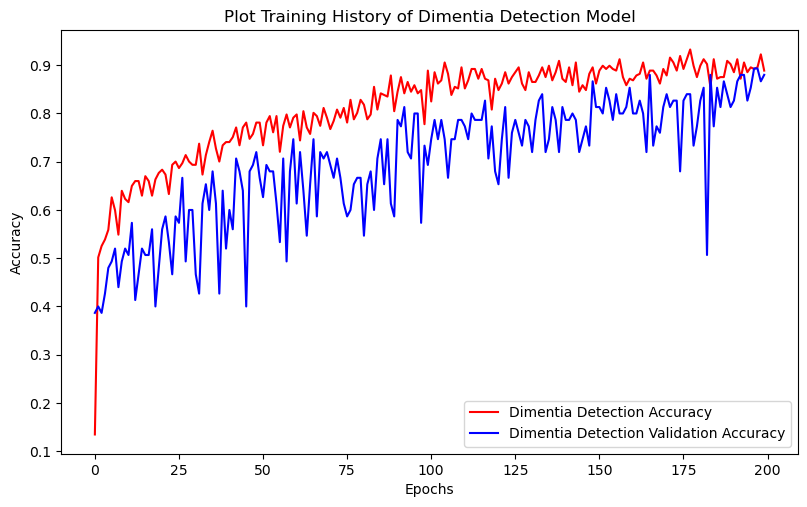

In [24]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(200), history.history['accuracy'], 'r', label='Dimentia Detection Accuracy')
plt.plot(range(200), history.history['val_accuracy'], 'b', label='Dimentia Detection Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training History of Dimentia Detection Model")
plt.legend()
plt.show()

### Plot Loss Performance

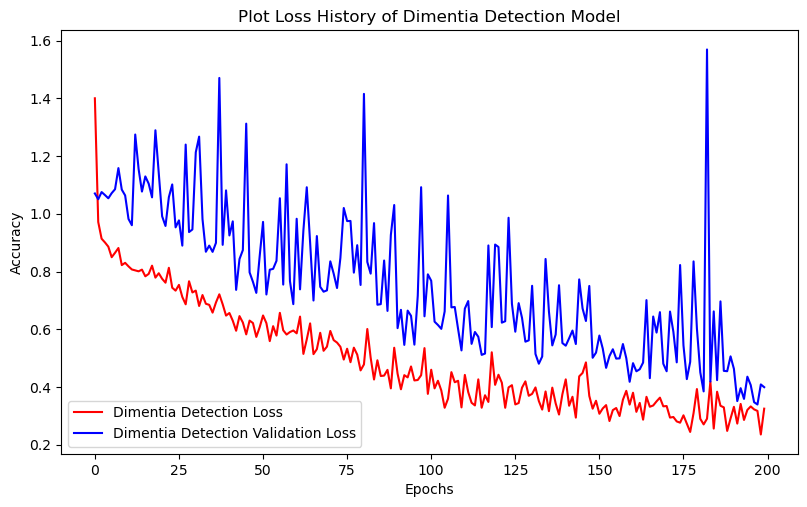

In [25]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(200), history.history['loss'], 'r', label='Dimentia Detection Loss')
plt.plot(range(200), history.history['val_loss'], 'b', label='Dimentia Detection Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Loss History of Dimentia Detection Model")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

# Assuming y_pred_prob is the predicted probabilities for each class
# in a multilabel classification problem

# Calculate ROC AUC for each class
roc_auc_scores = roc_auc_score(y_test, y_pred_prob, average='macro')  # or 'micro', 'weighted' depending on your requirements

print(f'ROC AUC Scores: {roc_auc_scores}')

ROC AUC Scores: 0.9404211188720656


In [32]:
from sklearn.metrics import average_precision_score

# Assuming y_pred_prob is the predicted probabilities for each class
# in a multilabel classification problem

# Calculate Precision-Recall AUC for each class
pr_auc_scores = average_precision_score(y_test, y_pred_prob, average='macro')  # or 'micro', 'weighted' depending on your requirements

print(f'Precision-Recall AUC Scores: {pr_auc_scores}')

Precision-Recall AUC Scores: 0.8629832356590166


In [33]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Make predictions on the test set
y_pred_prob = al_classifier.multi_modal_model.predict([X_tabular_test, X_images_test])

# Assuming y_pred_prob is the predicted probabilities for each class
# in a multilabel classification problem

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate and print F1 score, recall, precision
f1 = f1_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')

print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')


3/3 [==============================] - 3s 983ms/step
F1 Score: 0.8472222222222223
Recall: 0.8133333333333334
Precision: 0.8840579710144928
